<a href="https://colab.research.google.com/github/Sattwikmaiti/DATA_SCIENCE_PROJECTS/blob/master/Time_Series_LSTM_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Monthly Milk Production using LSTM(RNN)
 Time Series Forecasting


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv('monthly_milk_production.csv',index_col='Date',parse_dates=True)
df.index.freq='MS'


df.head()



,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


<Axes: xlabel='Date'>

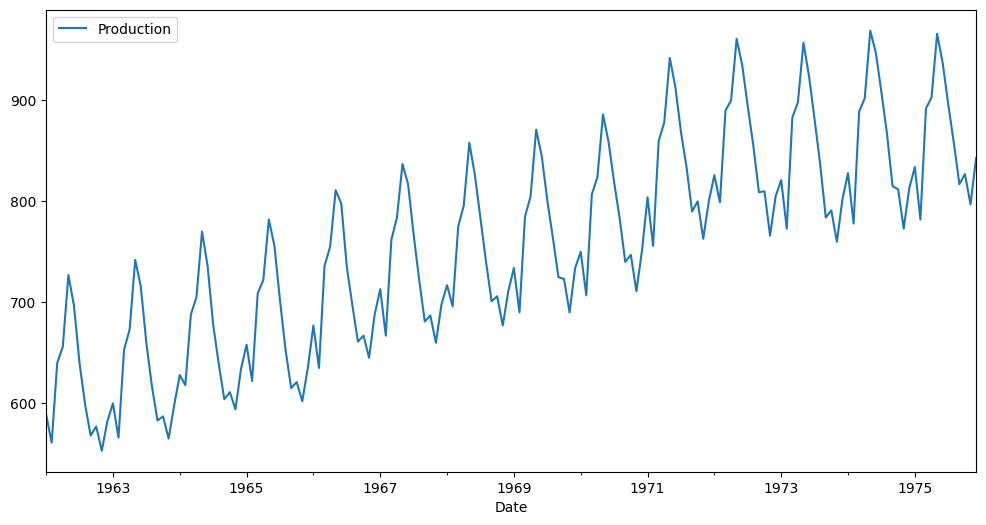

In [2]:
df.plot(figsize=(12,6))

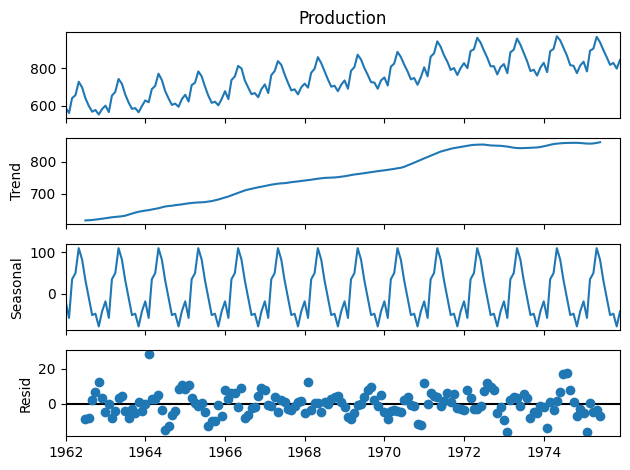

In [3]:

from statsmodels.tsa.seasonal import seasonal_decompose


results = seasonal_decompose(df['Production'])
results.plot();


In [4]:

len(df)

168

train = df.iloc[:156]
test = df.iloc[156:]


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


df.head(),df.tail()


(            Production
 Date                  
 1962-01-01         589
 1962-02-01         561
 1962-03-01         640
 1962-04-01         656
 1962-05-01         727,
             Production
 Date                  
 1975-08-01         858
 1975-09-01         817
 1975-10-01         827
 1975-11-01         797
 1975-12-01         843)

In [5]:

scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)


scaled_train[:10]


array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [6]:

from keras.preprocessing.sequence import TimeseriesGenerator


# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)


X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.08653846 0.01923077 0.20913462]
Predict this y: 
 [[0.24759615]]


In [7]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [8]:
model.fit(generator,epochs=50)

Epoch 1/50
144/144 [==============================] - 6s 15ms/step - loss: 0.0455
Epoch 2/50
144/144 [==============================] - 2s 15ms/step - loss: 0.0252
Epoch 3/50
144/144 [==============================] - 3s 20ms/step - loss: 0.0190
Epoch 4/50
144/144 [==============================] - 5s 37ms/step - loss: 0.0132
Epoch 5/50
144/144 [==============================] - 3s 20ms/step - loss: 0.0095
Epoch 6/50
144/144 [==============================] - 2s 15ms/step - loss: 0.0064
Epoch 7/50
144/144 [==============================] - 7s 46ms/step - loss: 0.0049
Epoch 8/50
144/144 [==============================] - 2s 15ms/step - loss: 0.0061
Epoch 9/50
144/144 [==============================] - 2s 15ms/step - loss: 0.0035
Epoch 10/50
144/144 [==============================] - 5s 33ms/step - loss: 0.0049
Epoch 11/50
144/144 [==============================] - 4s 25ms/step - loss: 0.0038
Epoch 12/50
144/144 [==============================] - 2s 15ms/step - loss: 0.0040
Epoch 13/50
1

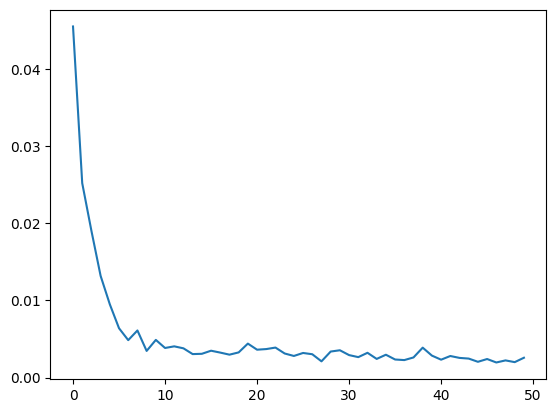

In [9]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [11]:
last_train_batch = scaled_train[-12:]


last_train_batch = last_train_batch.reshape((1, n_input, n_features))


model.predict(last_train_batch)

#array([[0.6046513]], dtype=float32)

scaled_test[0]

#array([0.67548077])

test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]

    # append the prediction into the array
    test_predictions.append(current_pred)

    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


test_predictions

1/1 [==============================] - 0s 20ms/step


[array([0.64182985], dtype=float32),
 array([0.615265], dtype=float32),
 array([0.80957735], dtype=float32),
 array([0.88713884], dtype=float32),
 array([1.0166408], dtype=float32),
 array([0.9905566], dtype=float32),
 array([0.9001695], dtype=float32),
 array([0.78826225], dtype=float32),
 array([0.67568684], dtype=float32),
 array([0.6386709], dtype=float32),
 array([0.5910429], dtype=float32),
 array([0.6279043], dtype=float32)]

<ipython-input-12-7d2c021c80f2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<Axes: xlabel='Date'>

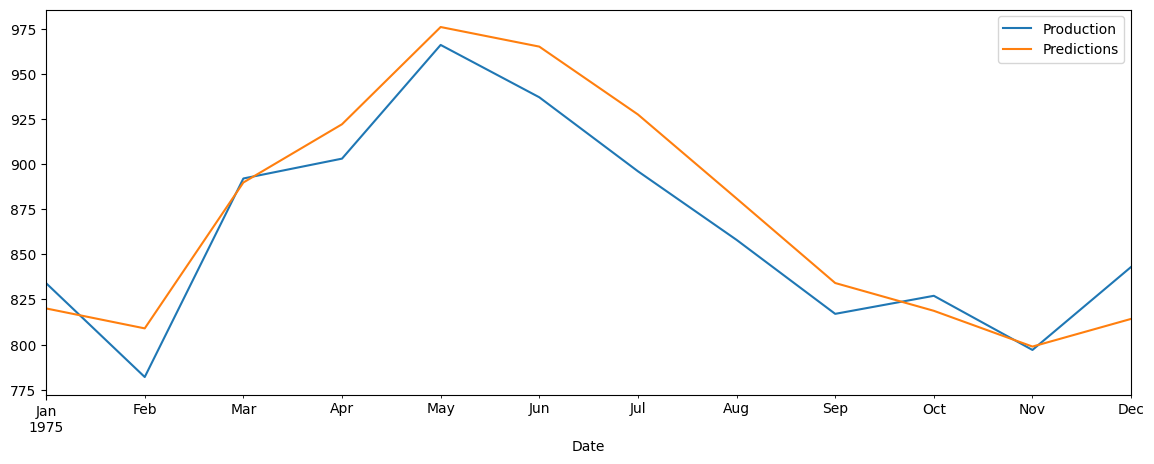

In [12]:

true_predictions = scaler.inverse_transform(test_predictions)


test['Predictions'] = true_predictions


test.plot(figsize=(14,5))


In [13]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

20.177639999868063
